<a href="https://colab.research.google.com/github/Ignas12345/Project_in_Computational_Biology/blob/main/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This part re-does the upscaling, but now with regularizaion from the underfitted "edge map".**

In [1]:
"""
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 3.10 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 186 (delta 40), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (186/186), 32.58 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (67/67), done.


# Import libs

In [2]:
from Project_in_Computational_Biology.models import *
from PIL import Image
from Project_in_Computational_Biology.plotting import plot
from Project_in_Computational_Biology.converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from Project_in_Computational_Biology.models.downsampler import Downsampler
from EdgeNet.EdgeNet import EdgeNet

from Project_in_Computational_Biology.utils.sr_utils import *

#comment the following three lines if running on CPU

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

#and uncomment this line
#dtype = torch.FloatTensor

upscaling_factor = 4

# Load image

In [3]:
orig_img = Image.open('Project_in_Computational_Biology/pictures/images_with_ground_truth_1/Corrupted_4x.jpg')
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [4]:
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 4000
reg_noise_std = 0.05

edge_regularization_weight = 0.5

In [5]:
net_image = generate_noise(gray_img, upscaling_factor)

In [6]:
net_input = image_to_tensor(net_image).type(dtype).detach()

In [7]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=upscaling_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [8]:
underfitted_edges = image_to_tensor(Image.open('underfitted_edges_HR.jpg')).type(dtype)

In [9]:
underfitted_edges_HR_img = Image.open('underfitted_edges_HR.jpg')
underfitted_edges_HR = image_to_tensor(underfitted_edges_HR_img).type(dtype)
underfitted_edges_LR = downsampler(underfitted_edges).type(dtype).detach()
underfitted_edges_LR_img = tensor_to_image(underfitted_edges_LR)

In [10]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
#Here you can choose which parameters of EdgeNet You want to use. Each can give different results. It becomes like a sort of game at this point...
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology/EdgeNet_parameters/model_parameters_3'))

<All keys matched successfully>

In [11]:
def closure():
    global i, net_input, edge_regularization_weight

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    edges = edgenet(out_HR) #this can either be LR or HR. If LR, make sure that the underfitted edges image is downscaled via downsampler

    total_loss = mse(out_LR, img_LR_var)  + edge_regularization_weight * mse(edges, underfitted_edges_HR)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_after_edges' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25


iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50


iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
iteration: 73
iteration: 74
iteration: 75


iteration: 76
iteration: 77
iteration: 78
iteration: 79
iteration: 80
iteration: 81
iteration: 82
iteration: 83
iteration: 84
iteration: 85
iteration: 86
iteration: 87
iteration: 88
iteration: 89
iteration: 90
iteration: 91
iteration: 92
iteration: 93
iteration: 94
iteration: 95
iteration: 96
iteration: 97
iteration: 98
iteration: 99
iteration: 100


iteration: 101
iteration: 102
iteration: 103
iteration: 104
iteration: 105
iteration: 106
iteration: 107
iteration: 108
iteration: 109
iteration: 110
iteration: 111
iteration: 112
iteration: 113
iteration: 114
iteration: 115
iteration: 116
iteration: 117
iteration: 118
iteration: 119
iteration: 120
iteration: 121
iteration: 122
iteration: 123
iteration: 124
iteration: 125


iteration: 126
iteration: 127
iteration: 128
iteration: 129
iteration: 130
iteration: 131
iteration: 132
iteration: 133
iteration: 134
iteration: 135
iteration: 136
iteration: 137
iteration: 138
iteration: 139
iteration: 140
iteration: 141
iteration: 142
iteration: 143
iteration: 144
iteration: 145
iteration: 146
iteration: 147
iteration: 148
iteration: 149
iteration: 150


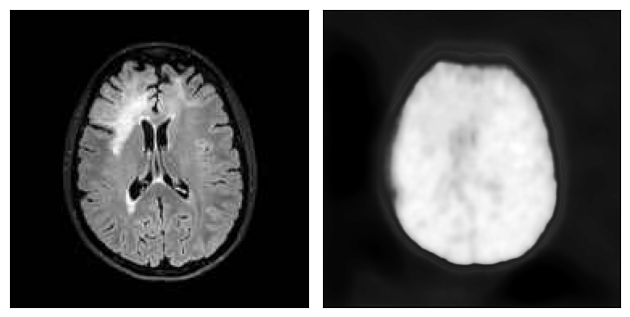

iteration: 151
iteration: 152
iteration: 153
iteration: 154
iteration: 155
iteration: 156
iteration: 157
iteration: 158
iteration: 159
iteration: 160
iteration: 161
iteration: 162
iteration: 163
iteration: 164
iteration: 165
iteration: 166
iteration: 167
iteration: 168
iteration: 169
iteration: 170
iteration: 171
iteration: 172
iteration: 173
iteration: 174
iteration: 175


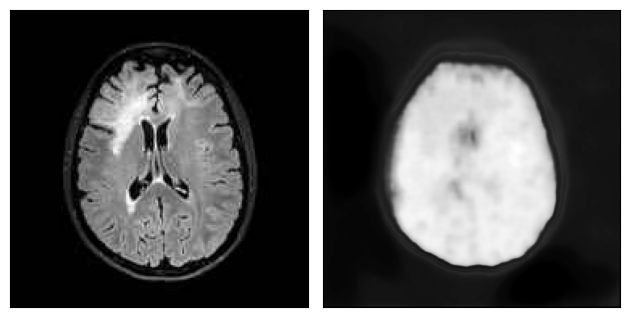

iteration: 176
iteration: 177
iteration: 178
iteration: 179
iteration: 180
iteration: 181
iteration: 182
iteration: 183
iteration: 184
iteration: 185
iteration: 186
iteration: 187
iteration: 188
iteration: 189
iteration: 190
iteration: 191
iteration: 192
iteration: 193
iteration: 194
iteration: 195
iteration: 196
iteration: 197
iteration: 198
iteration: 199
iteration: 200


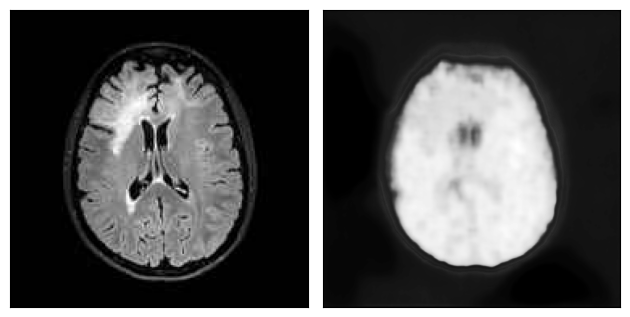

iteration: 201
iteration: 202
iteration: 203
iteration: 204
iteration: 205
iteration: 206
iteration: 207
iteration: 208
iteration: 209
iteration: 210
iteration: 211
iteration: 212
iteration: 213
iteration: 214
iteration: 215
iteration: 216
iteration: 217
iteration: 218
iteration: 219
iteration: 220
iteration: 221
iteration: 222
iteration: 223
iteration: 224
iteration: 225


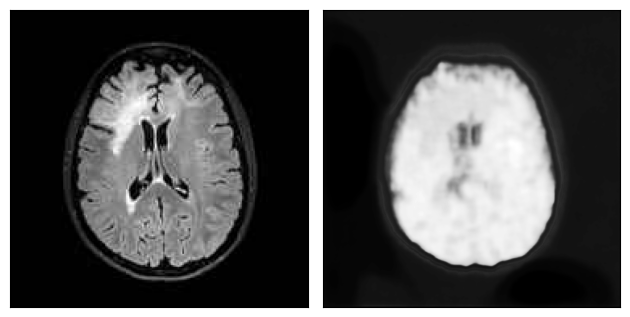

iteration: 226
iteration: 227
iteration: 228
iteration: 229
iteration: 230
iteration: 231
iteration: 232
iteration: 233
iteration: 234
iteration: 235
iteration: 236
iteration: 237
iteration: 238
iteration: 239
iteration: 240
iteration: 241
iteration: 242
iteration: 243
iteration: 244
iteration: 245
iteration: 246
iteration: 247
iteration: 248
iteration: 249
iteration: 250


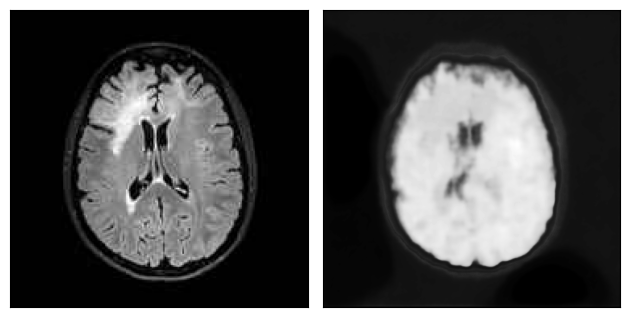

iteration: 251
iteration: 252
iteration: 253
iteration: 254
iteration: 255
iteration: 256
iteration: 257
iteration: 258
iteration: 259
iteration: 260
iteration: 261
iteration: 262
iteration: 263
iteration: 264
iteration: 265
iteration: 266
iteration: 267
iteration: 268
iteration: 269
iteration: 270
iteration: 271
iteration: 272
iteration: 273
iteration: 274
iteration: 275


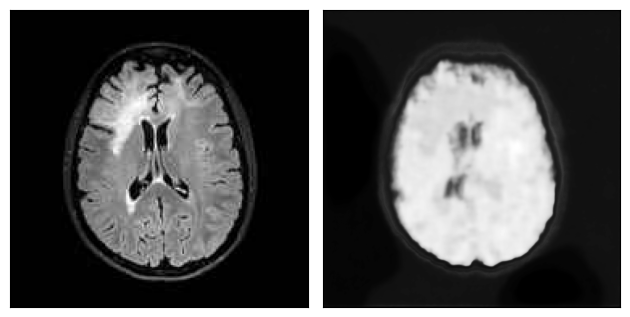

iteration: 276
iteration: 277
iteration: 278
iteration: 279
iteration: 280
iteration: 281
iteration: 282
iteration: 283
iteration: 284
iteration: 285
iteration: 286
iteration: 287
iteration: 288
iteration: 289
iteration: 290
iteration: 291
iteration: 292
iteration: 293
iteration: 294
iteration: 295
iteration: 296
iteration: 297
iteration: 298
iteration: 299
iteration: 300


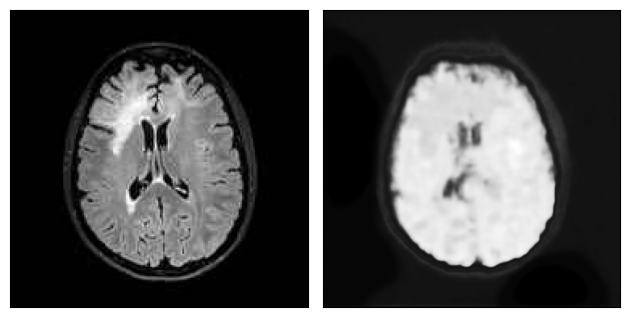

iteration: 301
iteration: 302
iteration: 303
iteration: 304
iteration: 305
iteration: 306
iteration: 307
iteration: 308
iteration: 309
iteration: 310
iteration: 311
iteration: 312
iteration: 313
iteration: 314
iteration: 315
iteration: 316
iteration: 317
iteration: 318
iteration: 319
iteration: 320
iteration: 321
iteration: 322
iteration: 323
iteration: 324
iteration: 325


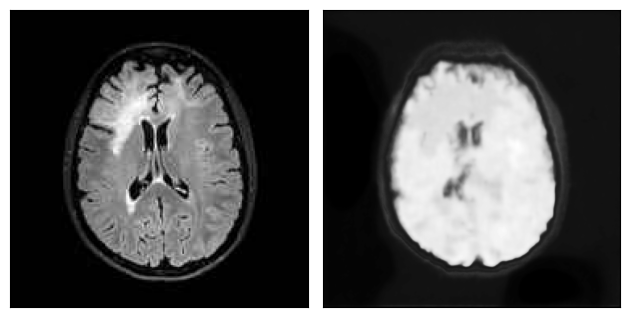

iteration: 326
iteration: 327
iteration: 328
iteration: 329
iteration: 330
iteration: 331
iteration: 332
iteration: 333
iteration: 334
iteration: 335
iteration: 336
iteration: 337
iteration: 338
iteration: 339
iteration: 340
iteration: 341
iteration: 342
iteration: 343
iteration: 344
iteration: 345
iteration: 346
iteration: 347
iteration: 348
iteration: 349
iteration: 350


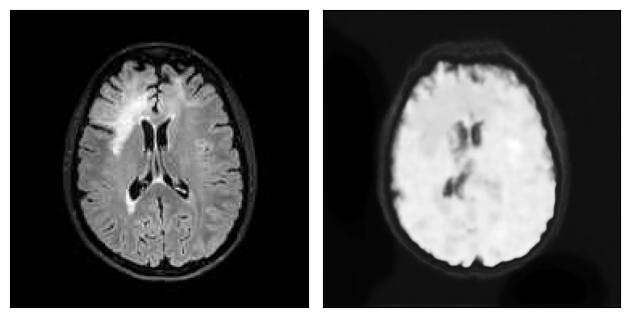

iteration: 351
iteration: 352
iteration: 353
iteration: 354
iteration: 355
iteration: 356
iteration: 357
iteration: 358
iteration: 359
iteration: 360
iteration: 361
iteration: 362
iteration: 363
iteration: 364
iteration: 365
iteration: 366
iteration: 367
iteration: 368
iteration: 369
iteration: 370
iteration: 371
iteration: 372
iteration: 373
iteration: 374
iteration: 375


iteration: 376
iteration: 377
iteration: 378
iteration: 379
iteration: 380
iteration: 381
iteration: 382
iteration: 383
iteration: 384
iteration: 385
iteration: 386
iteration: 387
iteration: 388
iteration: 389
iteration: 390
iteration: 391
iteration: 392
iteration: 393
iteration: 394
iteration: 395
iteration: 396
iteration: 397
iteration: 398
iteration: 399
iteration: 400


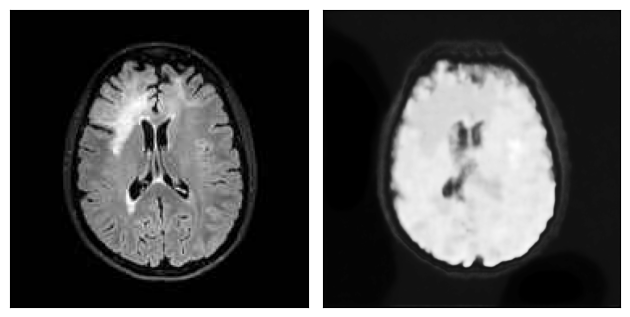

iteration: 401
iteration: 402
iteration: 403
iteration: 404
iteration: 405
iteration: 406
iteration: 407
iteration: 408
iteration: 409
iteration: 410
iteration: 411
iteration: 412
iteration: 413
iteration: 414
iteration: 415
iteration: 416
iteration: 417
iteration: 418
iteration: 419
iteration: 420
iteration: 421
iteration: 422
iteration: 423
iteration: 424
iteration: 425


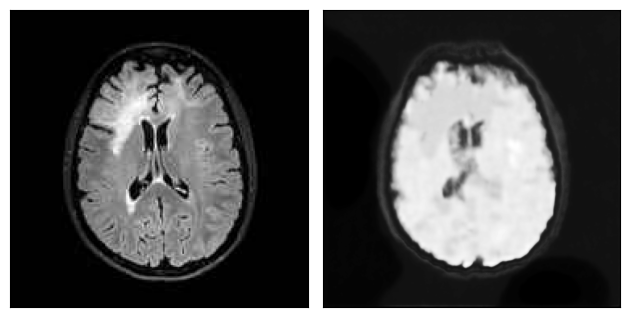

iteration: 426
iteration: 427
iteration: 428
iteration: 429
iteration: 430
iteration: 431
iteration: 432
iteration: 433
iteration: 434
iteration: 435
iteration: 436
iteration: 437
iteration: 438
iteration: 439
iteration: 440
iteration: 441
iteration: 442
iteration: 443
iteration: 444
iteration: 445
iteration: 446
iteration: 447
iteration: 448
iteration: 449
iteration: 450


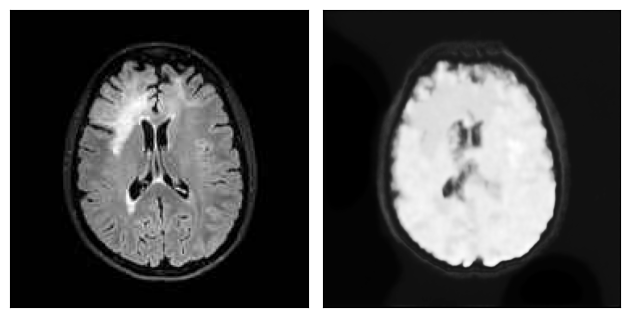

iteration: 451
iteration: 452
iteration: 453
iteration: 454
iteration: 455
iteration: 456
iteration: 457
iteration: 458
iteration: 459
iteration: 460
iteration: 461
iteration: 462
iteration: 463
iteration: 464
iteration: 465
iteration: 466
iteration: 467
iteration: 468
iteration: 469
iteration: 470
iteration: 471
iteration: 472
iteration: 473
iteration: 474
iteration: 475


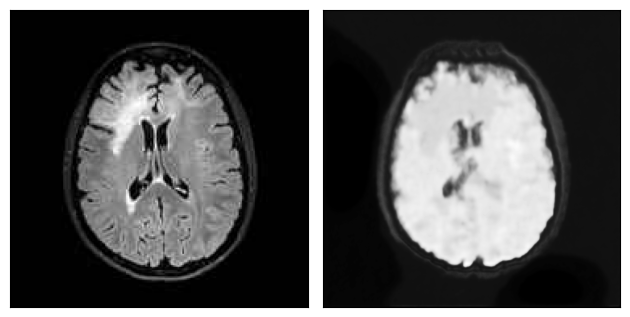

iteration: 476
iteration: 477
iteration: 478
iteration: 479
iteration: 480
iteration: 481
iteration: 482
iteration: 483
iteration: 484
iteration: 485
iteration: 486
iteration: 487
iteration: 488
iteration: 489
iteration: 490
iteration: 491
iteration: 492
iteration: 493
iteration: 494
iteration: 495
iteration: 496
iteration: 497
iteration: 498
iteration: 499
iteration: 500


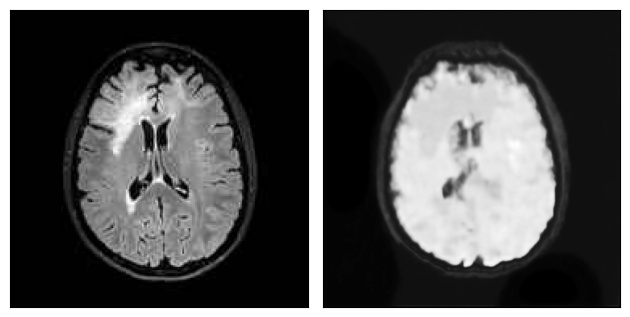

iteration: 501
iteration: 502
iteration: 503
iteration: 504
iteration: 505
iteration: 506
iteration: 507
iteration: 508
iteration: 509
iteration: 510
iteration: 511
iteration: 512
iteration: 513
iteration: 514
iteration: 515
iteration: 516
iteration: 517
iteration: 518
iteration: 519
iteration: 520
iteration: 521
iteration: 522
iteration: 523
iteration: 524
iteration: 525


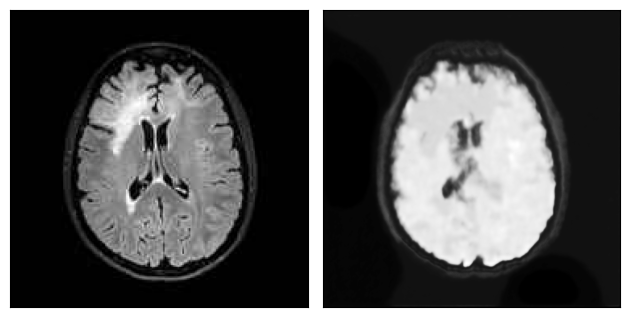

iteration: 526
iteration: 527
iteration: 528
iteration: 529
iteration: 530
iteration: 531
iteration: 532
iteration: 533
iteration: 534
iteration: 535
iteration: 536
iteration: 537
iteration: 538
iteration: 539
iteration: 540
iteration: 541
iteration: 542
iteration: 543
iteration: 544
iteration: 545
iteration: 546
iteration: 547
iteration: 548
iteration: 549
iteration: 550


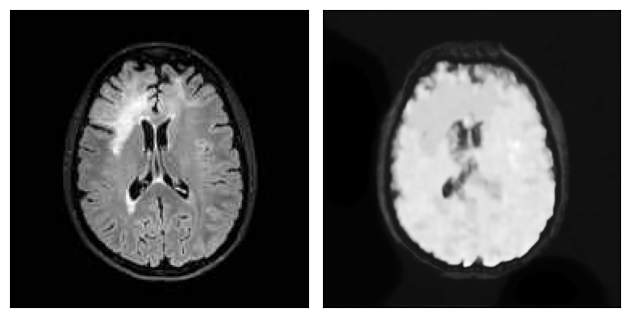

iteration: 551
iteration: 552
iteration: 553
iteration: 554
iteration: 555
iteration: 556
iteration: 557
iteration: 558
iteration: 559
iteration: 560
iteration: 561
iteration: 562
iteration: 563
iteration: 564
iteration: 565
iteration: 566
iteration: 567
iteration: 568
iteration: 569
iteration: 570
iteration: 571
iteration: 572
iteration: 573
iteration: 574
iteration: 575


iteration: 576
iteration: 577
iteration: 578
iteration: 579
iteration: 580
iteration: 581
iteration: 582
iteration: 583
iteration: 584
iteration: 585
iteration: 586
iteration: 587
iteration: 588
iteration: 589
iteration: 590
iteration: 591
iteration: 592
iteration: 593
iteration: 594
iteration: 595
iteration: 596
iteration: 597
iteration: 598
iteration: 599
iteration: 600


iteration: 601
iteration: 602
iteration: 603
iteration: 604
iteration: 605
iteration: 606
iteration: 607
iteration: 608
iteration: 609
iteration: 610
iteration: 611
iteration: 612
iteration: 613
iteration: 614
iteration: 615
iteration: 616
iteration: 617
iteration: 618
iteration: 619
iteration: 620
iteration: 621
iteration: 622
iteration: 623
iteration: 624
iteration: 625


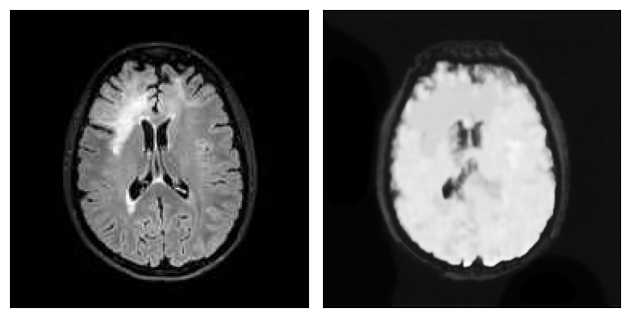

iteration: 626
iteration: 627
iteration: 628
iteration: 629
iteration: 630
iteration: 631
iteration: 632
iteration: 633
iteration: 634
iteration: 635
iteration: 636
iteration: 637
iteration: 638
iteration: 639
iteration: 640
iteration: 641
iteration: 642
iteration: 643
iteration: 644
iteration: 645
iteration: 646
iteration: 647
iteration: 648
iteration: 649
iteration: 650


iteration: 651
iteration: 652
iteration: 653
iteration: 654
iteration: 655
iteration: 656
iteration: 657
iteration: 658
iteration: 659
iteration: 660
iteration: 661
iteration: 662
iteration: 663
iteration: 664
iteration: 665
iteration: 666
iteration: 667
iteration: 668
iteration: 669
iteration: 670
iteration: 671
iteration: 672
iteration: 673
iteration: 674
iteration: 675


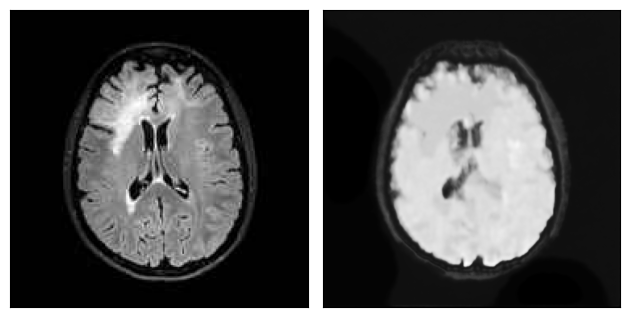

iteration: 676
iteration: 677
iteration: 678
iteration: 679
iteration: 680
iteration: 681
iteration: 682
iteration: 683
iteration: 684
iteration: 685
iteration: 686
iteration: 687
iteration: 688
iteration: 689
iteration: 690
iteration: 691
iteration: 692
iteration: 693
iteration: 694
iteration: 695
iteration: 696
iteration: 697
iteration: 698
iteration: 699
iteration: 700


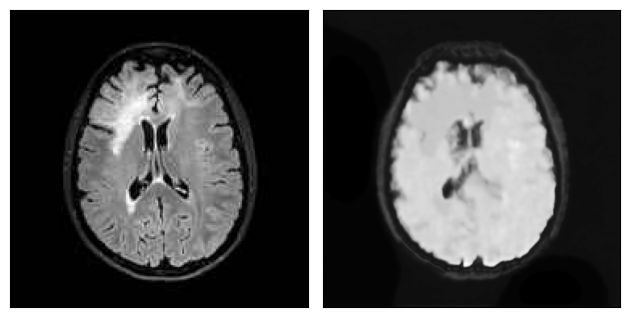

iteration: 701
iteration: 702
iteration: 703
iteration: 704
iteration: 705
iteration: 706
iteration: 707
iteration: 708
iteration: 709
iteration: 710
iteration: 711
iteration: 712
iteration: 713
iteration: 714
iteration: 715
iteration: 716
iteration: 717
iteration: 718
iteration: 719
iteration: 720
iteration: 721
iteration: 722
iteration: 723
iteration: 724
iteration: 725


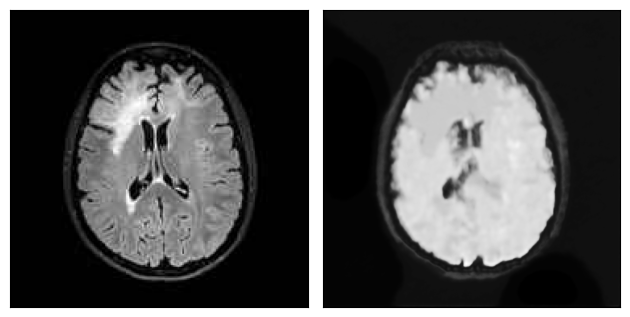

iteration: 726
iteration: 727
iteration: 728
iteration: 729
iteration: 730
iteration: 731
iteration: 732
iteration: 733
iteration: 734
iteration: 735
iteration: 736
iteration: 737
iteration: 738
iteration: 739
iteration: 740
iteration: 741
iteration: 742
iteration: 743
iteration: 744
iteration: 745
iteration: 746
iteration: 747
iteration: 748
iteration: 749
iteration: 750


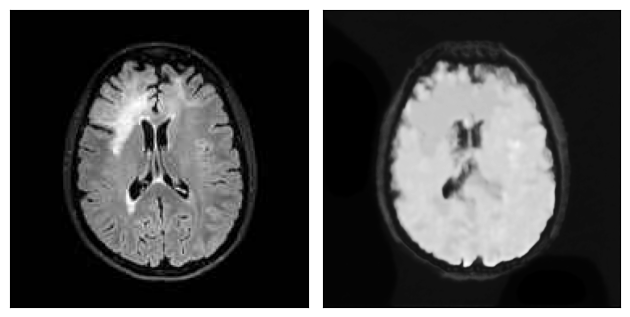

iteration: 751
iteration: 752
iteration: 753
iteration: 754
iteration: 755
iteration: 756
iteration: 757
iteration: 758
iteration: 759
iteration: 760
iteration: 761
iteration: 762
iteration: 763
iteration: 764
iteration: 765
iteration: 766
iteration: 767
iteration: 768
iteration: 769
iteration: 770
iteration: 771
iteration: 772
iteration: 773
iteration: 774
iteration: 775


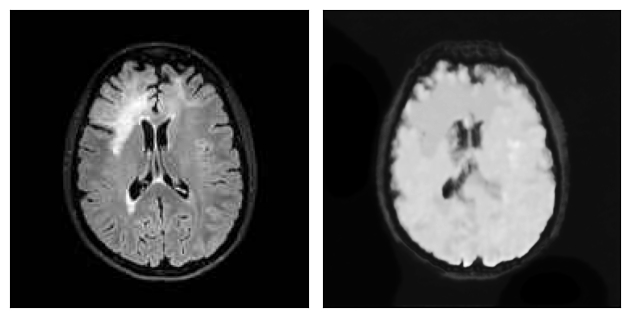

iteration: 776
iteration: 777
iteration: 778
iteration: 779
iteration: 780
iteration: 781
iteration: 782
iteration: 783
iteration: 784
iteration: 785
iteration: 786
iteration: 787
iteration: 788
iteration: 789
iteration: 790
iteration: 791
iteration: 792
iteration: 793
iteration: 794
iteration: 795
iteration: 796
iteration: 797
iteration: 798
iteration: 799
iteration: 800


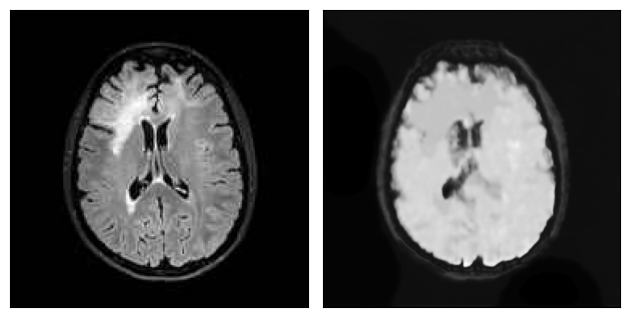

iteration: 801
iteration: 802
iteration: 803
iteration: 804
iteration: 805
iteration: 806
iteration: 807
iteration: 808
iteration: 809
iteration: 810
iteration: 811
iteration: 812
iteration: 813
iteration: 814
iteration: 815
iteration: 816
iteration: 817
iteration: 818
iteration: 819
iteration: 820
iteration: 821
iteration: 822
iteration: 823
iteration: 824
iteration: 825


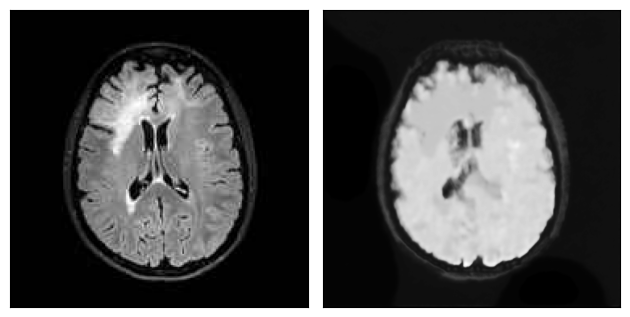

iteration: 826
iteration: 827
iteration: 828
iteration: 829
iteration: 830
iteration: 831
iteration: 832
iteration: 833
iteration: 834
iteration: 835
iteration: 836
iteration: 837
iteration: 838
iteration: 839
iteration: 840
iteration: 841
iteration: 842
iteration: 843
iteration: 844
iteration: 845
iteration: 846
iteration: 847
iteration: 848
iteration: 849
iteration: 850


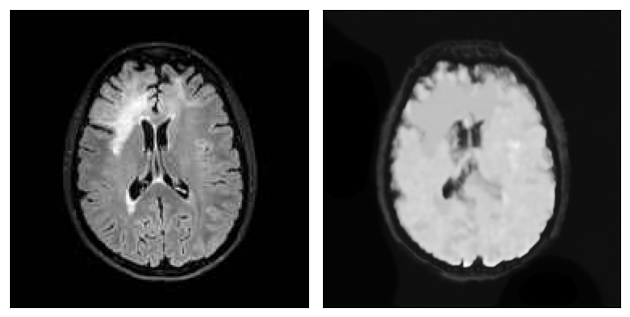

iteration: 851
iteration: 852
iteration: 853
iteration: 854
iteration: 855
iteration: 856
iteration: 857
iteration: 858
iteration: 859
iteration: 860
iteration: 861
iteration: 862
iteration: 863
iteration: 864
iteration: 865
iteration: 866
iteration: 867
iteration: 868
iteration: 869
iteration: 870
iteration: 871
iteration: 872
iteration: 873
iteration: 874
iteration: 875


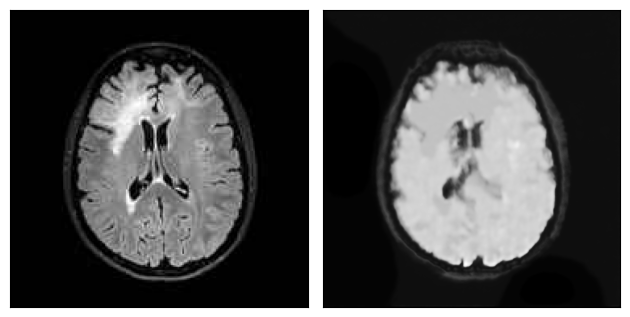

iteration: 876
iteration: 877
iteration: 878
iteration: 879
iteration: 880
iteration: 881
iteration: 882
iteration: 883
iteration: 884
iteration: 885
iteration: 886
iteration: 887
iteration: 888
iteration: 889
iteration: 890
iteration: 891
iteration: 892
iteration: 893
iteration: 894
iteration: 895
iteration: 896
iteration: 897
iteration: 898
iteration: 899
iteration: 900


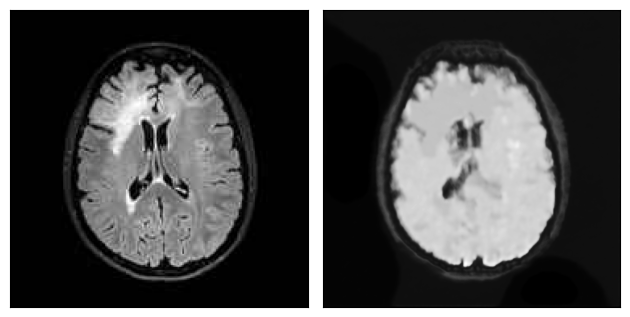

iteration: 901
iteration: 902
iteration: 903
iteration: 904
iteration: 905
iteration: 906
iteration: 907
iteration: 908
iteration: 909
iteration: 910
iteration: 911
iteration: 912
iteration: 913
iteration: 914
iteration: 915
iteration: 916
iteration: 917
iteration: 918
iteration: 919
iteration: 920
iteration: 921
iteration: 922
iteration: 923
iteration: 924
iteration: 925


iteration: 926
iteration: 927
iteration: 928
iteration: 929
iteration: 930
iteration: 931
iteration: 932
iteration: 933
iteration: 934
iteration: 935
iteration: 936
iteration: 937
iteration: 938
iteration: 939
iteration: 940
iteration: 941
iteration: 942
iteration: 943
iteration: 944
iteration: 945
iteration: 946
iteration: 947
iteration: 948
iteration: 949
iteration: 950


iteration: 951
iteration: 952
iteration: 953
iteration: 954
iteration: 955
iteration: 956
iteration: 957
iteration: 958
iteration: 959
iteration: 960
iteration: 961
iteration: 962
iteration: 963
iteration: 964
iteration: 965
iteration: 966
iteration: 967
iteration: 968
iteration: 969
iteration: 970
iteration: 971
iteration: 972
iteration: 973
iteration: 974
iteration: 975


iteration: 976
iteration: 977
iteration: 978
iteration: 979
iteration: 980
iteration: 981
iteration: 982
iteration: 983
iteration: 984
iteration: 985
iteration: 986
iteration: 987
iteration: 988
iteration: 989
iteration: 990
iteration: 991
iteration: 992
iteration: 993
iteration: 994
iteration: 995
iteration: 996
iteration: 997
iteration: 998
iteration: 999
iteration: 1000


iteration: 1001
iteration: 1002
iteration: 1003
iteration: 1004
iteration: 1005
iteration: 1006
iteration: 1007
iteration: 1008
iteration: 1009
iteration: 1010
iteration: 1011
iteration: 1012
iteration: 1013
iteration: 1014
iteration: 1015
iteration: 1016
iteration: 1017
iteration: 1018
iteration: 1019
iteration: 1020
iteration: 1021
iteration: 1022
iteration: 1023
iteration: 1024
iteration: 1025


iteration: 1026
iteration: 1027
iteration: 1028
iteration: 1029
iteration: 1030
iteration: 1031
iteration: 1032
iteration: 1033
iteration: 1034
iteration: 1035
iteration: 1036
iteration: 1037
iteration: 1038
iteration: 1039
iteration: 1040
iteration: 1041
iteration: 1042
iteration: 1043
iteration: 1044
iteration: 1045
iteration: 1046
iteration: 1047
iteration: 1048
iteration: 1049
iteration: 1050


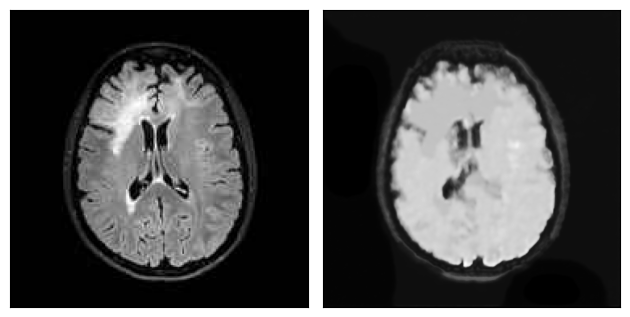

iteration: 1051
iteration: 1052
iteration: 1053
iteration: 1054
iteration: 1055
iteration: 1056
iteration: 1057
iteration: 1058
iteration: 1059
iteration: 1060
iteration: 1061
iteration: 1062
iteration: 1063
iteration: 1064
iteration: 1065
iteration: 1066
iteration: 1067
iteration: 1068
iteration: 1069
iteration: 1070
iteration: 1071
iteration: 1072
iteration: 1073
iteration: 1074
iteration: 1075


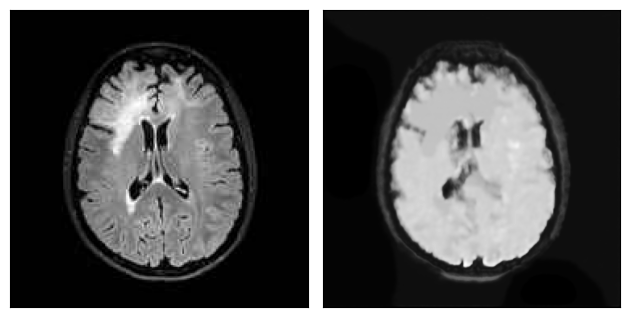

iteration: 1076
iteration: 1077
iteration: 1078
iteration: 1079
iteration: 1080
iteration: 1081
iteration: 1082
iteration: 1083
iteration: 1084
iteration: 1085
iteration: 1086
iteration: 1087
iteration: 1088
iteration: 1089
iteration: 1090
iteration: 1091
iteration: 1092
iteration: 1093
iteration: 1094
iteration: 1095
iteration: 1096
iteration: 1097
iteration: 1098
iteration: 1099
iteration: 1100


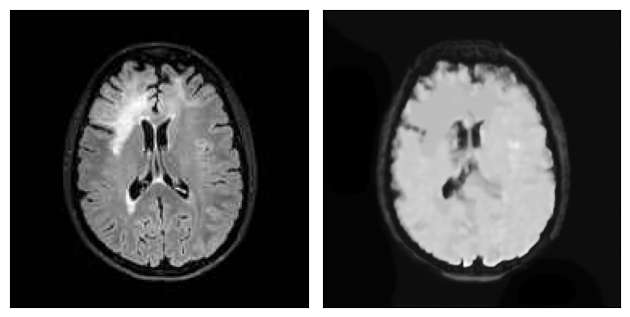

iteration: 1101
iteration: 1102
iteration: 1103
iteration: 1104
iteration: 1105
iteration: 1106
iteration: 1107
iteration: 1108
iteration: 1109
iteration: 1110
iteration: 1111
iteration: 1112
iteration: 1113
iteration: 1114
iteration: 1115
iteration: 1116
iteration: 1117
iteration: 1118
iteration: 1119
iteration: 1120
iteration: 1121
iteration: 1122
iteration: 1123
iteration: 1124
iteration: 1125


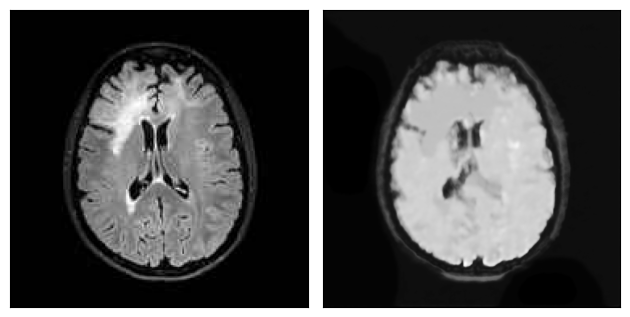

iteration: 1126
iteration: 1127
iteration: 1128
iteration: 1129
iteration: 1130
iteration: 1131
iteration: 1132
iteration: 1133
iteration: 1134
iteration: 1135
iteration: 1136
iteration: 1137
iteration: 1138
iteration: 1139
iteration: 1140
iteration: 1141
iteration: 1142
iteration: 1143
iteration: 1144
iteration: 1145
iteration: 1146
iteration: 1147
iteration: 1148
iteration: 1149
iteration: 1150


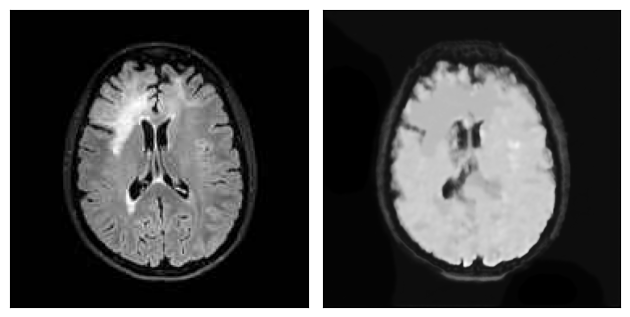

iteration: 1151
iteration: 1152
iteration: 1153
iteration: 1154
iteration: 1155
iteration: 1156
iteration: 1157
iteration: 1158
iteration: 1159
iteration: 1160
iteration: 1161
iteration: 1162
iteration: 1163
iteration: 1164
iteration: 1165
iteration: 1166
iteration: 1167
iteration: 1168
iteration: 1169
iteration: 1170
iteration: 1171
iteration: 1172
iteration: 1173
iteration: 1174
iteration: 1175


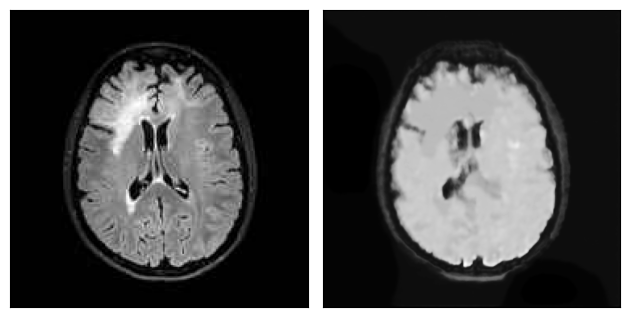

iteration: 1176
iteration: 1177
iteration: 1178
iteration: 1179
iteration: 1180
iteration: 1181
iteration: 1182
iteration: 1183
iteration: 1184
iteration: 1185
iteration: 1186
iteration: 1187
iteration: 1188
iteration: 1189
iteration: 1190
iteration: 1191
iteration: 1192
iteration: 1193
iteration: 1194
iteration: 1195
iteration: 1196
iteration: 1197
iteration: 1198
iteration: 1199
iteration: 1200


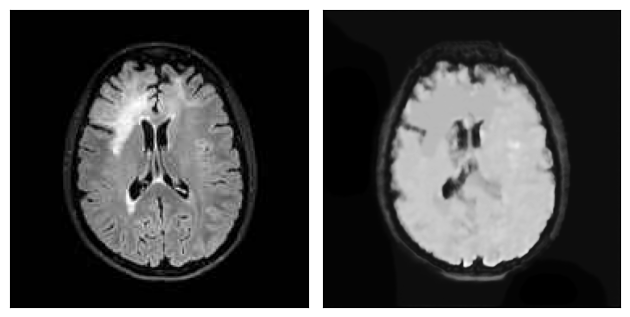

iteration: 1201
iteration: 1202
iteration: 1203
iteration: 1204
iteration: 1205
iteration: 1206
iteration: 1207
iteration: 1208
iteration: 1209
iteration: 1210
iteration: 1211
iteration: 1212
iteration: 1213
iteration: 1214
iteration: 1215
iteration: 1216
iteration: 1217
iteration: 1218
iteration: 1219
iteration: 1220
iteration: 1221
iteration: 1222
iteration: 1223
iteration: 1224
iteration: 1225


iteration: 1226
iteration: 1227
iteration: 1228
iteration: 1229
iteration: 1230
iteration: 1231
iteration: 1232
iteration: 1233
iteration: 1234
iteration: 1235
iteration: 1236
iteration: 1237
iteration: 1238
iteration: 1239
iteration: 1240
iteration: 1241
iteration: 1242
iteration: 1243
iteration: 1244
iteration: 1245
iteration: 1246
iteration: 1247
iteration: 1248
iteration: 1249
iteration: 1250


iteration: 1251
iteration: 1252
iteration: 1253
iteration: 1254
iteration: 1255
iteration: 1256
iteration: 1257
iteration: 1258
iteration: 1259
iteration: 1260
iteration: 1261
iteration: 1262
iteration: 1263
iteration: 1264
iteration: 1265
iteration: 1266
iteration: 1267
iteration: 1268
iteration: 1269
iteration: 1270
iteration: 1271
iteration: 1272
iteration: 1273
iteration: 1274
iteration: 1275


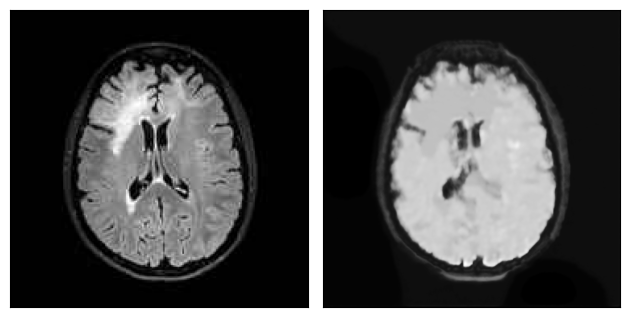

iteration: 1276
iteration: 1277
iteration: 1278
iteration: 1279
iteration: 1280
iteration: 1281
iteration: 1282
iteration: 1283
iteration: 1284
iteration: 1285
iteration: 1286
iteration: 1287
iteration: 1288
iteration: 1289
iteration: 1290
iteration: 1291
iteration: 1292
iteration: 1293
iteration: 1294
iteration: 1295
iteration: 1296
iteration: 1297
iteration: 1298
iteration: 1299
iteration: 1300


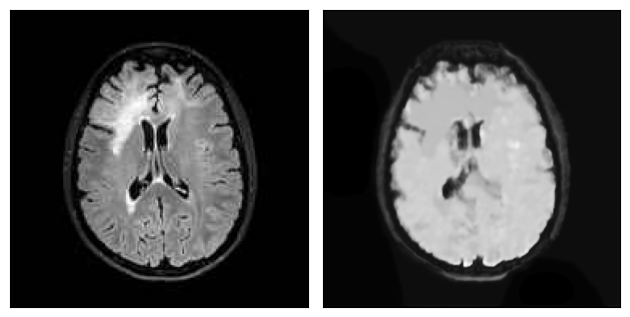

iteration: 1301
iteration: 1302
iteration: 1303
iteration: 1304
iteration: 1305
iteration: 1306
iteration: 1307
iteration: 1308
iteration: 1309
iteration: 1310
iteration: 1311
iteration: 1312
iteration: 1313
iteration: 1314
iteration: 1315
iteration: 1316
iteration: 1317
iteration: 1318
iteration: 1319
iteration: 1320
iteration: 1321
iteration: 1322
iteration: 1323
iteration: 1324
iteration: 1325


iteration: 1326
iteration: 1327
iteration: 1328
iteration: 1329
iteration: 1330
iteration: 1331
iteration: 1332
iteration: 1333
iteration: 1334
iteration: 1335
iteration: 1336
iteration: 1337
iteration: 1338
iteration: 1339
iteration: 1340
iteration: 1341
iteration: 1342
iteration: 1343
iteration: 1344
iteration: 1345
iteration: 1346
iteration: 1347
iteration: 1348
iteration: 1349
iteration: 1350


iteration: 1351
iteration: 1352
iteration: 1353
iteration: 1354
iteration: 1355
iteration: 1356
iteration: 1357
iteration: 1358
iteration: 1359
iteration: 1360
iteration: 1361
iteration: 1362
iteration: 1363
iteration: 1364
iteration: 1365
iteration: 1366
iteration: 1367
iteration: 1368
iteration: 1369
iteration: 1370
iteration: 1371
iteration: 1372
iteration: 1373
iteration: 1374
iteration: 1375


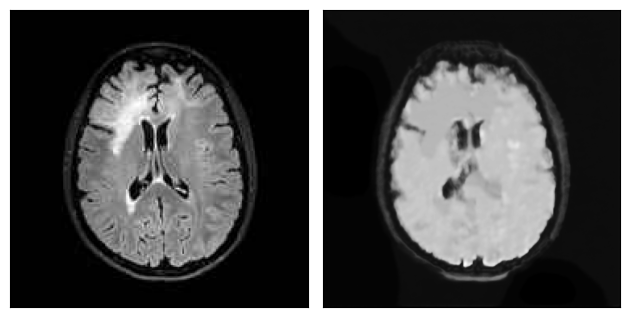

iteration: 1376
iteration: 1377
iteration: 1378
iteration: 1379
iteration: 1380
iteration: 1381
iteration: 1382
iteration: 1383
iteration: 1384
iteration: 1385
iteration: 1386
iteration: 1387
iteration: 1388
iteration: 1389
iteration: 1390
iteration: 1391
iteration: 1392
iteration: 1393
iteration: 1394
iteration: 1395
iteration: 1396
iteration: 1397
iteration: 1398
iteration: 1399
iteration: 1400


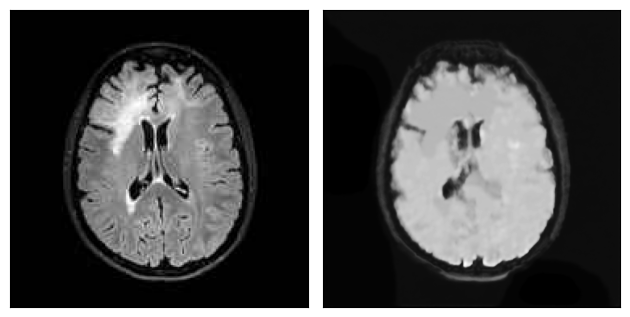

iteration: 1401
iteration: 1402
iteration: 1403
iteration: 1404
iteration: 1405
iteration: 1406
iteration: 1407
iteration: 1408
iteration: 1409
iteration: 1410
iteration: 1411
iteration: 1412
iteration: 1413
iteration: 1414
iteration: 1415
iteration: 1416
iteration: 1417
iteration: 1418
iteration: 1419
iteration: 1420
iteration: 1421
iteration: 1422
iteration: 1423
iteration: 1424
iteration: 1425


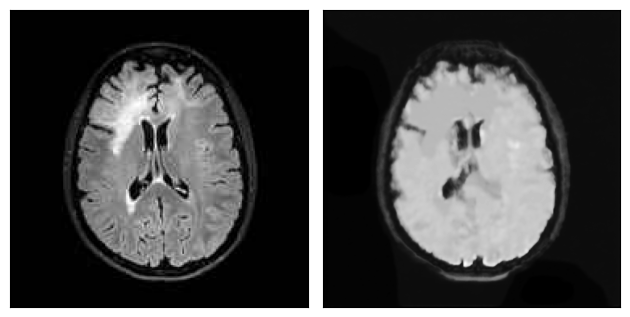

iteration: 1426
iteration: 1427
iteration: 1428
iteration: 1429
iteration: 1430
iteration: 1431
iteration: 1432
iteration: 1433
iteration: 1434
iteration: 1435
iteration: 1436
iteration: 1437
iteration: 1438
iteration: 1439
iteration: 1440
iteration: 1441
iteration: 1442
iteration: 1443
iteration: 1444
iteration: 1445
iteration: 1446
iteration: 1447
iteration: 1448
iteration: 1449
iteration: 1450


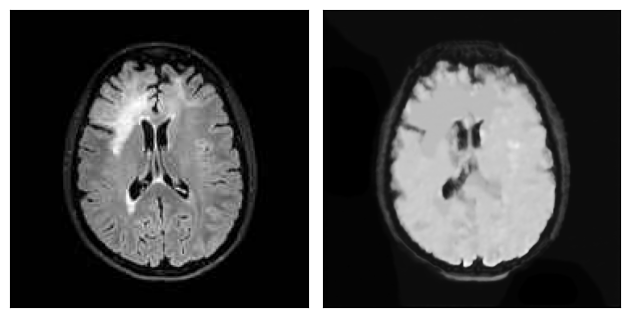

iteration: 1451
iteration: 1452
iteration: 1453
iteration: 1454
iteration: 1455
iteration: 1456
iteration: 1457
iteration: 1458
iteration: 1459
iteration: 1460
iteration: 1461
iteration: 1462
iteration: 1463
iteration: 1464
iteration: 1465
iteration: 1466
iteration: 1467
iteration: 1468
iteration: 1469
iteration: 1470
iteration: 1471
iteration: 1472
iteration: 1473
iteration: 1474
iteration: 1475


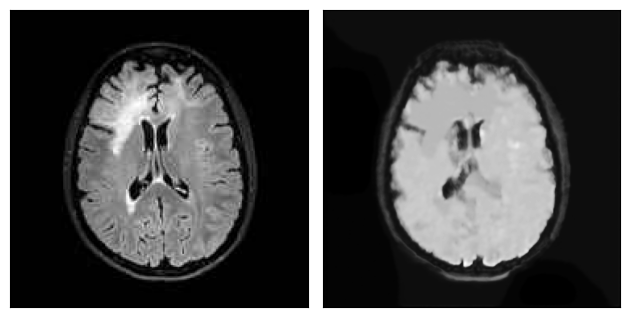

iteration: 1476
iteration: 1477
iteration: 1478
iteration: 1479
iteration: 1480
iteration: 1481
iteration: 1482
iteration: 1483
iteration: 1484
iteration: 1485
iteration: 1486
iteration: 1487
iteration: 1488
iteration: 1489
iteration: 1490
iteration: 1491
iteration: 1492
iteration: 1493
iteration: 1494
iteration: 1495
iteration: 1496
iteration: 1497
iteration: 1498
iteration: 1499
iteration: 1500


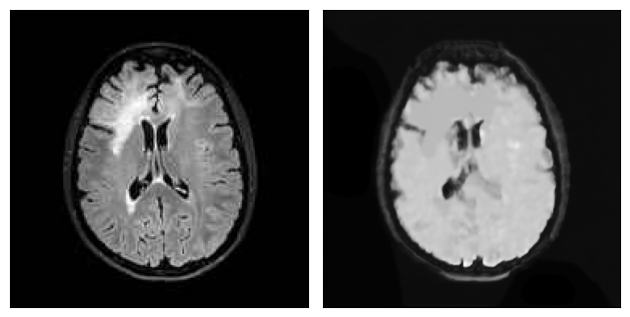

iteration: 1501
iteration: 1502
iteration: 1503
iteration: 1504
iteration: 1505
iteration: 1506
iteration: 1507
iteration: 1508
iteration: 1509
iteration: 1510
iteration: 1511
iteration: 1512
iteration: 1513
iteration: 1514
iteration: 1515
iteration: 1516
iteration: 1517
iteration: 1518
iteration: 1519
iteration: 1520
iteration: 1521
iteration: 1522
iteration: 1523
iteration: 1524
iteration: 1525


iteration: 1526
iteration: 1527
iteration: 1528
iteration: 1529
iteration: 1530
iteration: 1531
iteration: 1532
iteration: 1533
iteration: 1534
iteration: 1535
iteration: 1536
iteration: 1537
iteration: 1538
iteration: 1539
iteration: 1540
iteration: 1541
iteration: 1542
iteration: 1543
iteration: 1544
iteration: 1545
iteration: 1546
iteration: 1547
iteration: 1548
iteration: 1549
iteration: 1550


iteration: 1551
iteration: 1552
iteration: 1553
iteration: 1554
iteration: 1555
iteration: 1556
iteration: 1557
iteration: 1558
iteration: 1559
iteration: 1560
iteration: 1561
iteration: 1562
iteration: 1563
iteration: 1564
iteration: 1565
iteration: 1566
iteration: 1567
iteration: 1568
iteration: 1569
iteration: 1570
iteration: 1571
iteration: 1572
iteration: 1573
iteration: 1574
iteration: 1575


iteration: 1576
iteration: 1577
iteration: 1578
iteration: 1579
iteration: 1580
iteration: 1581
iteration: 1582
iteration: 1583
iteration: 1584
iteration: 1585
iteration: 1586
iteration: 1587
iteration: 1588
iteration: 1589
iteration: 1590
iteration: 1591
iteration: 1592
iteration: 1593
iteration: 1594
iteration: 1595
iteration: 1596
iteration: 1597
iteration: 1598
iteration: 1599
iteration: 1600


iteration: 1601
iteration: 1602
iteration: 1603
iteration: 1604
iteration: 1605
iteration: 1606
iteration: 1607
iteration: 1608
iteration: 1609
iteration: 1610
iteration: 1611
iteration: 1612
iteration: 1613
iteration: 1614
iteration: 1615
iteration: 1616
iteration: 1617
iteration: 1618
iteration: 1619
iteration: 1620
iteration: 1621
iteration: 1622
iteration: 1623
iteration: 1624
iteration: 1625


iteration: 1626
iteration: 1627
iteration: 1628
iteration: 1629
iteration: 1630
iteration: 1631
iteration: 1632
iteration: 1633
iteration: 1634
iteration: 1635
iteration: 1636
iteration: 1637
iteration: 1638
iteration: 1639
iteration: 1640
iteration: 1641
iteration: 1642
iteration: 1643
iteration: 1644
iteration: 1645
iteration: 1646
iteration: 1647
iteration: 1648
iteration: 1649
iteration: 1650


iteration: 1651
iteration: 1652
iteration: 1653
iteration: 1654
iteration: 1655
iteration: 1656
iteration: 1657
iteration: 1658
iteration: 1659
iteration: 1660
iteration: 1661
iteration: 1662
iteration: 1663
iteration: 1664
iteration: 1665
iteration: 1666
iteration: 1667
iteration: 1668
iteration: 1669
iteration: 1670
iteration: 1671
iteration: 1672
iteration: 1673
iteration: 1674
iteration: 1675


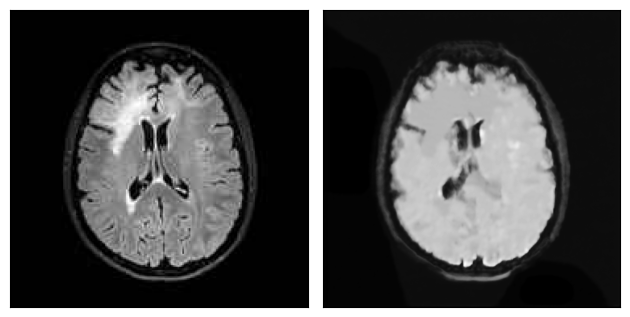

iteration: 1676
iteration: 1677
iteration: 1678
iteration: 1679
iteration: 1680
iteration: 1681
iteration: 1682
iteration: 1683
iteration: 1684
iteration: 1685
iteration: 1686
iteration: 1687
iteration: 1688
iteration: 1689
iteration: 1690
iteration: 1691
iteration: 1692
iteration: 1693
iteration: 1694
iteration: 1695
iteration: 1696
iteration: 1697
iteration: 1698
iteration: 1699
iteration: 1700


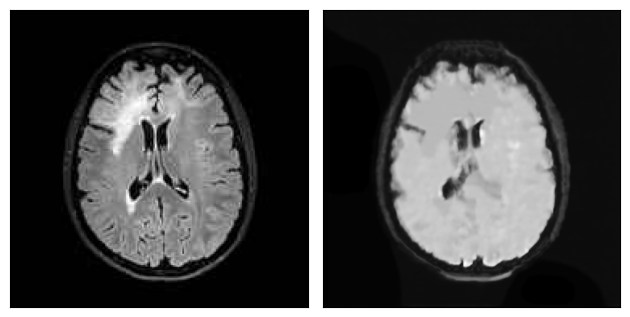

iteration: 1701
iteration: 1702
iteration: 1703
iteration: 1704
iteration: 1705
iteration: 1706
iteration: 1707
iteration: 1708
iteration: 1709
iteration: 1710
iteration: 1711
iteration: 1712
iteration: 1713
iteration: 1714
iteration: 1715
iteration: 1716
iteration: 1717
iteration: 1718
iteration: 1719
iteration: 1720
iteration: 1721
iteration: 1722
iteration: 1723
iteration: 1724
iteration: 1725


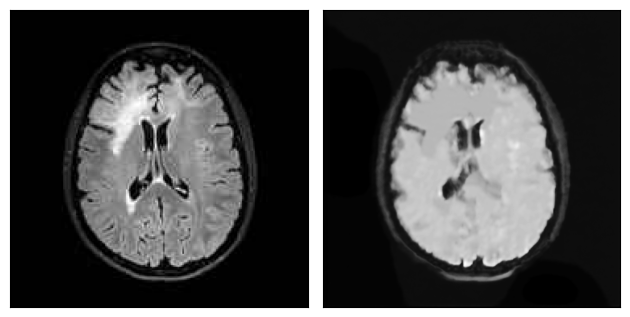

iteration: 1726
iteration: 1727
iteration: 1728
iteration: 1729
iteration: 1730
iteration: 1731
iteration: 1732
iteration: 1733
iteration: 1734
iteration: 1735
iteration: 1736
iteration: 1737
iteration: 1738
iteration: 1739
iteration: 1740
iteration: 1741
iteration: 1742
iteration: 1743
iteration: 1744
iteration: 1745
iteration: 1746
iteration: 1747
iteration: 1748
iteration: 1749
iteration: 1750


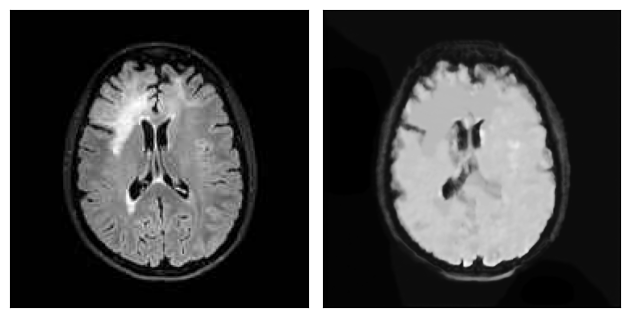

iteration: 1751
iteration: 1752
iteration: 1753
iteration: 1754
iteration: 1755
iteration: 1756
iteration: 1757
iteration: 1758
iteration: 1759
iteration: 1760
iteration: 1761
iteration: 1762
iteration: 1763
iteration: 1764
iteration: 1765
iteration: 1766
iteration: 1767
iteration: 1768
iteration: 1769
iteration: 1770
iteration: 1771
iteration: 1772
iteration: 1773
iteration: 1774
iteration: 1775


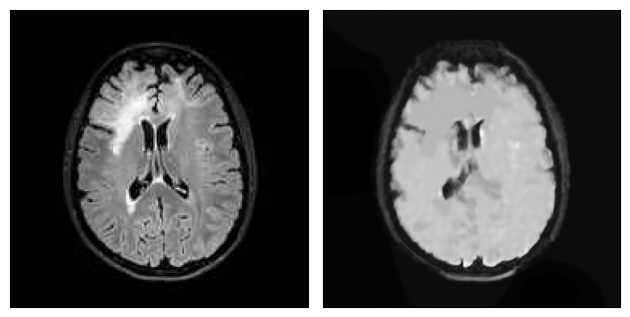

iteration: 1776
iteration: 1777
iteration: 1778
iteration: 1779
iteration: 1780
iteration: 1781
iteration: 1782
iteration: 1783
iteration: 1784
iteration: 1785
iteration: 1786
iteration: 1787
iteration: 1788
iteration: 1789
iteration: 1790
iteration: 1791
iteration: 1792
iteration: 1793
iteration: 1794
iteration: 1795
iteration: 1796
iteration: 1797
iteration: 1798
iteration: 1799
iteration: 1800


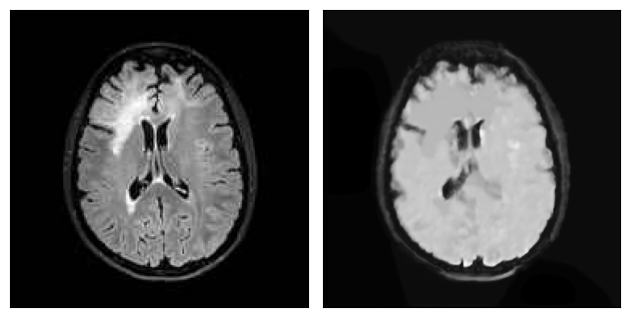

iteration: 1801
iteration: 1802
iteration: 1803
iteration: 1804
iteration: 1805
iteration: 1806
iteration: 1807
iteration: 1808
iteration: 1809
iteration: 1810
iteration: 1811
iteration: 1812
iteration: 1813
iteration: 1814
iteration: 1815
iteration: 1816
iteration: 1817
iteration: 1818
iteration: 1819
iteration: 1820
iteration: 1821
iteration: 1822
iteration: 1823
iteration: 1824
iteration: 1825


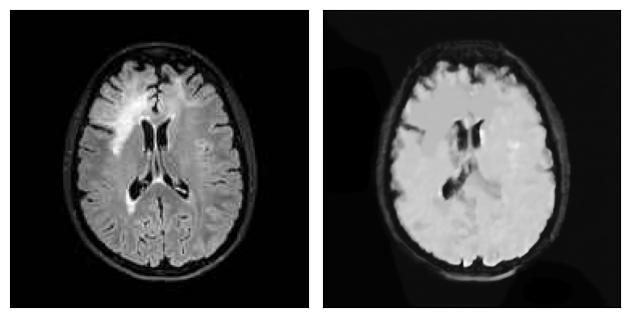

iteration: 1826
iteration: 1827
iteration: 1828
iteration: 1829
iteration: 1830
iteration: 1831
iteration: 1832
iteration: 1833
iteration: 1834
iteration: 1835
iteration: 1836
iteration: 1837
iteration: 1838
iteration: 1839
iteration: 1840
iteration: 1841
iteration: 1842
iteration: 1843
iteration: 1844
iteration: 1845
iteration: 1846
iteration: 1847
iteration: 1848
iteration: 1849
iteration: 1850


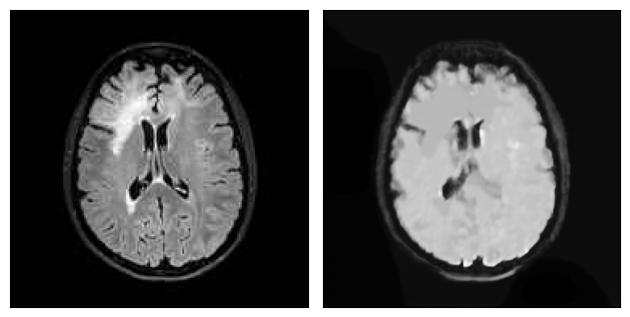

iteration: 1851
iteration: 1852
iteration: 1853
iteration: 1854
iteration: 1855
iteration: 1856
iteration: 1857
iteration: 1858
iteration: 1859
iteration: 1860
iteration: 1861
iteration: 1862
iteration: 1863
iteration: 1864
iteration: 1865
iteration: 1866
iteration: 1867
iteration: 1868
iteration: 1869
iteration: 1870
iteration: 1871
iteration: 1872
iteration: 1873
iteration: 1874
iteration: 1875


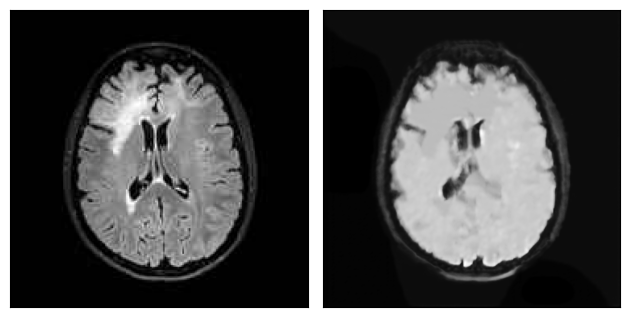

iteration: 1876
iteration: 1877
iteration: 1878
iteration: 1879
iteration: 1880
iteration: 1881
iteration: 1882
iteration: 1883
iteration: 1884
iteration: 1885
iteration: 1886
iteration: 1887
iteration: 1888
iteration: 1889
iteration: 1890
iteration: 1891
iteration: 1892
iteration: 1893
iteration: 1894
iteration: 1895
iteration: 1896
iteration: 1897
iteration: 1898
iteration: 1899
iteration: 1900


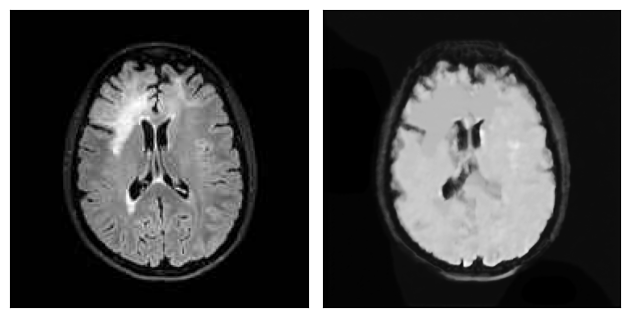

iteration: 1901
iteration: 1902
iteration: 1903
iteration: 1904
iteration: 1905
iteration: 1906
iteration: 1907
iteration: 1908
iteration: 1909
iteration: 1910
iteration: 1911
iteration: 1912
iteration: 1913
iteration: 1914
iteration: 1915
iteration: 1916
iteration: 1917
iteration: 1918
iteration: 1919
iteration: 1920
iteration: 1921
iteration: 1922
iteration: 1923
iteration: 1924
iteration: 1925


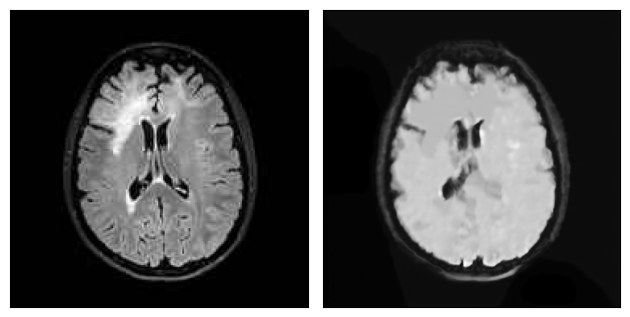

iteration: 1926
iteration: 1927
iteration: 1928
iteration: 1929
iteration: 1930
iteration: 1931
iteration: 1932
iteration: 1933
iteration: 1934
iteration: 1935
iteration: 1936
iteration: 1937
iteration: 1938
iteration: 1939
iteration: 1940
iteration: 1941
iteration: 1942
iteration: 1943
iteration: 1944
iteration: 1945
iteration: 1946
iteration: 1947
iteration: 1948
iteration: 1949
iteration: 1950


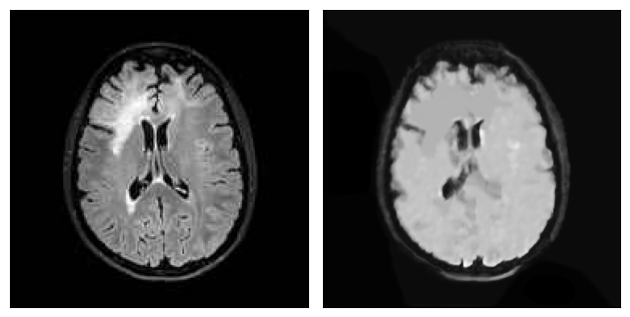

iteration: 1951
iteration: 1952
iteration: 1953
iteration: 1954
iteration: 1955
iteration: 1956
iteration: 1957
iteration: 1958
iteration: 1959
iteration: 1960
iteration: 1961
iteration: 1962
iteration: 1963
iteration: 1964
iteration: 1965
iteration: 1966
iteration: 1967
iteration: 1968
iteration: 1969
iteration: 1970
iteration: 1971
iteration: 1972
iteration: 1973
iteration: 1974
iteration: 1975


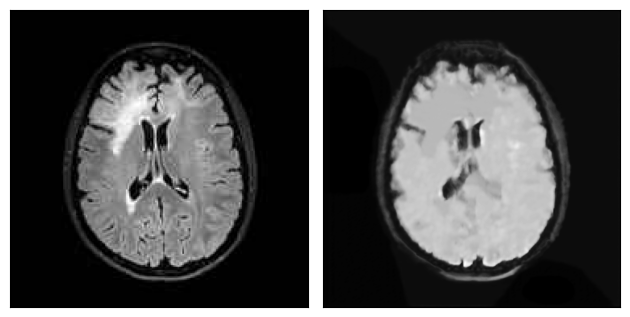

iteration: 1976
iteration: 1977
iteration: 1978
iteration: 1979
iteration: 1980
iteration: 1981
iteration: 1982
iteration: 1983
iteration: 1984
iteration: 1985
iteration: 1986
iteration: 1987
iteration: 1988
iteration: 1989
iteration: 1990
iteration: 1991
iteration: 1992
iteration: 1993
iteration: 1994
iteration: 1995
iteration: 1996
iteration: 1997
iteration: 1998
iteration: 1999
iteration: 2000


iteration: 2001
iteration: 2002
iteration: 2003
iteration: 2004
iteration: 2005
iteration: 2006
iteration: 2007
iteration: 2008
iteration: 2009
iteration: 2010
iteration: 2011


KeyboardInterrupt: 

In [12]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

**As you can see, we start recovering the noise as the number of iterations grows. We want to somehow avoid that.**